# Ascent vs Descent Investigation

In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from scipy.integrate import dblquad

## Visualizing Input Data
The input data is given as the negative space of the surface of the stair step.

In [187]:
# Load the CSV file
file_path = "data/singleWide.csv"
data = pd.read_csv(file_path)

Input the dimensions of the step below: width, depth, and height.

In [307]:
max_x, max_y, max_h = 60, 30, 20  # Define your max values

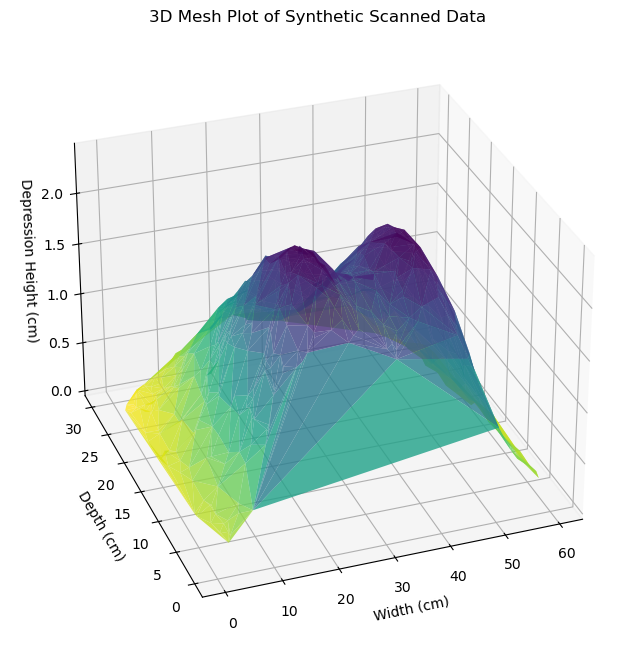

In [423]:
# Ensure the data satisfies the bounds
data = data[(data["X"] <= max_x) & (data["Y"] <= max_y) & (data["H"] <= max_h)]
X, Y, H = data['X'], data['Y'], data['H']

# Create a 3D mesh plot for visualization
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, H, cmap="viridis_r", edgecolor="none", alpha = 0.8)
ax.set_xlabel("Width (cm)")
ax.set_ylabel("Depth (cm)")
ax.set_zlabel("Depression Height (cm)")
plt.title("3D Mesh Plot of Synthetic Scanned Data")
ax.view_init(elev=30, azim=250)
plt.savefig("figures/ascentDescentInputNegative.png", dpi=300)
plt.show()

# Stair Height
stair_height = max_h
stair_H = stair_height - H

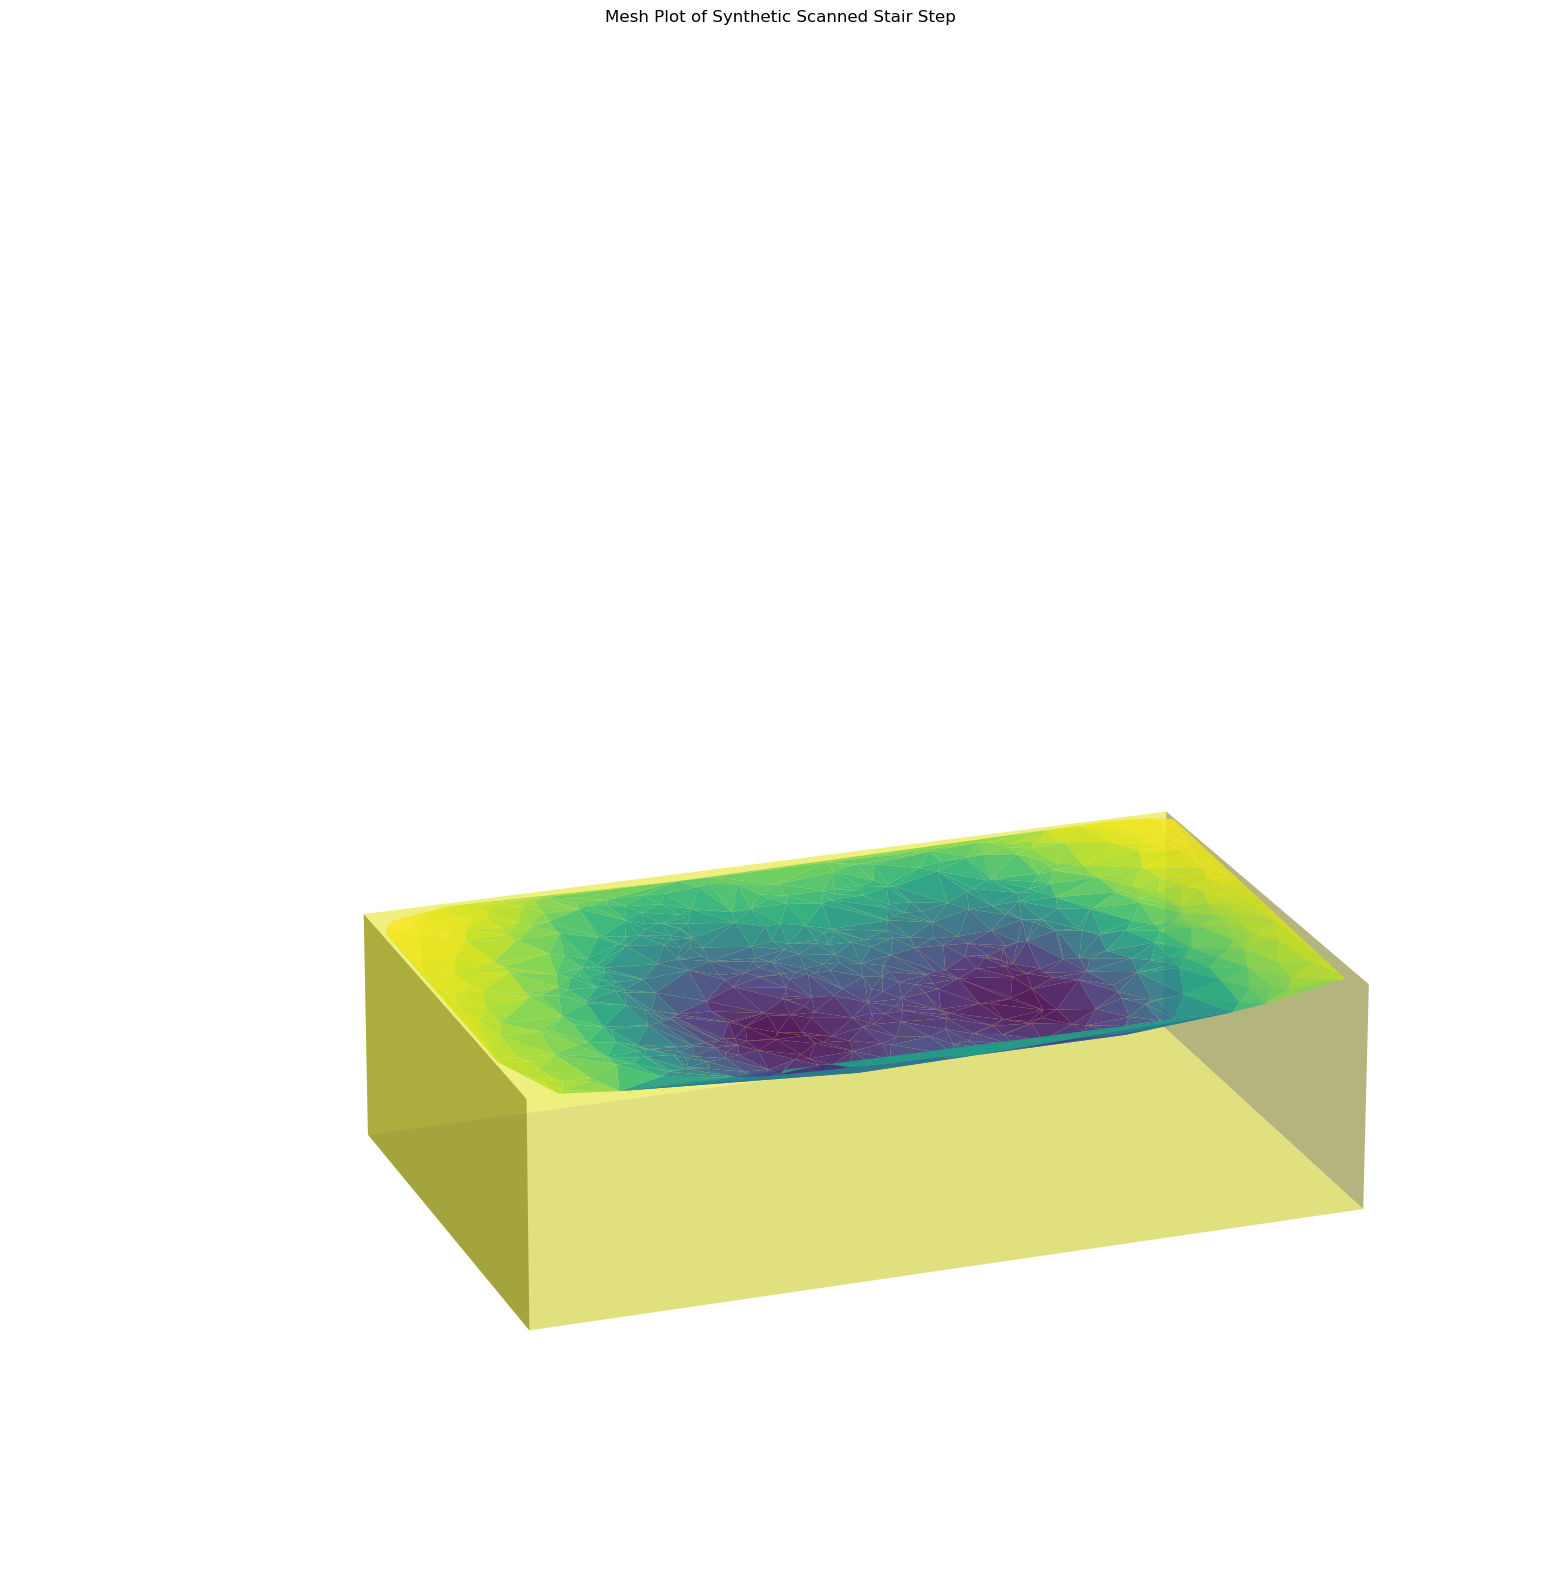

In [425]:
# Plotting
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the box - bottom and top
# Bottom rectangle (0,0,0) to (max_x, max_y, 0)
ax.plot_surface([[0, max_x], [0, max_x]], [[0, 0], [max_y, max_y]], np.zeros((2, 2)), color='yellow', alpha=0.5)

ax.plot_surface(np.array([[0, 0], [0, 0]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
#ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[0, 0], [0, 0]]), np.array([[0, 0], [stair_height, stair_height]]), color='gray', alpha=0.5)
ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[max_y, max_y], [max_y, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
ax.plot_surface(np.array([[max_x, max_x], [max_x, max_x]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)

# Top mesh surface (X, Y, stair_H)
ax.plot_trisurf(X, Y, stair_H, cmap='viridis', edgecolor='none', alpha = 0.9)

# Set labels
ax.set_title('Mesh Plot of Synthetic Scanned Stair Step')
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Height (cm)')

#ax.set_xlim(0, max_x)  # X-axis length
#ax.set_ylim(0, max_y)   # Y-axis length
#ax.set_zlim(0, max_h)

scaling = np.array([60, 50, 60])
ax.auto_scale_xyz(*[[0, scale] for scale in scaling])

ax.view_init(elev=20, azim=250)
ax.set_axis_off()
plt.savefig("figures/ascentdescentinput.png", dpi=300)
plt.show()

## Fitting Data
This fits the data to n Gaussian distributions.

In [205]:
n_gaussians = 4

In [ ]:
# Function to model a single 2D Gaussian distribution
def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude):
    x, y = xy
    return amplitude * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)))

# Function to model a sum of n_gaussians 2D Gaussian distributions
def sum_of_gaussians(xy, *params):
    n_gaussians = len(params) // 5
    result = np.zeros_like(xy[0])
    for i in range(n_gaussians):
        x0, y0, sigma_x, sigma_y, amplitude = params[i*5:(i+1)*5]
        result += gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude)
    return result

# Initial parameter guesses (randomly distributed means, variances, and amplitudes)
initial_params = []
for _ in range(n_gaussians):
    initial_params += [
        np.random.uniform(0, max_x),  # x0
        np.random.uniform(0, max_y),  # y0
        np.random.uniform(0.1, max_x / 4),  # sigma_x
        np.random.uniform(0.1, max_y / 4),  # sigma_y
        np.random.uniform(1, max_h/10)  # amplitude
    ]

# Fit the data to the sum of Gaussians
xy = np.vstack((X, Y))
lower_bounds = [0, 0, 0.1, 0.1, 0.5] * n_gaussians  # Minimum values for x0, y0, sigma_x, sigma_y, amplitude
upper_bounds = [max_x, max_y, max_x, max_y, max_h] * n_gaussians  # Maximum values
params, _ = curve_fit(sum_of_gaussians, xy, H, p0=initial_params, bounds=(lower_bounds, upper_bounds), maxfev=100000)

# Generate a mesh for visualization
x_mesh = np.linspace(0, max_x, 100)
y_mesh = np.linspace(0, max_y, 100)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
xy_mesh = np.vstack((X_mesh.ravel(), Y_mesh.ravel()))

# Calculate the best-fit surface values
H_fit = sum_of_gaussians(xy_mesh, *params).reshape(100, 100)

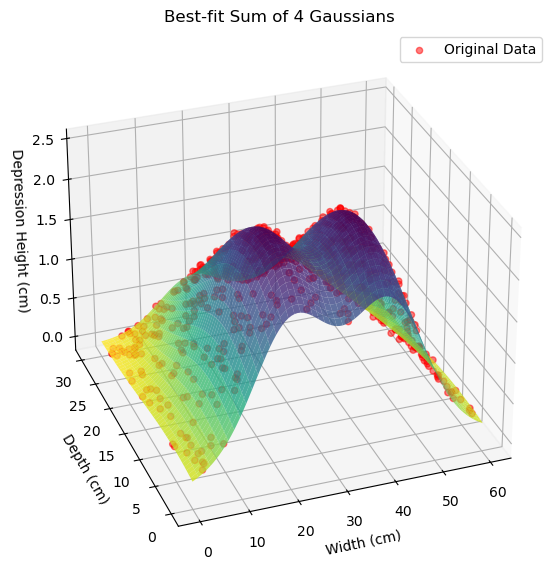

In [419]:
# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.scatter(X, Y, H, color='red', label='Original Data', alpha=0.5)

# Plot the best-fit Gaussian surface
ax.plot_surface(X_mesh, Y_mesh, H_fit, cmap='viridis_r', alpha=0.8)

# Set labels and title
ax.set_title(f'Best-fit Sum of {n_gaussians} Gaussians')
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Depression Height (cm)')
ax.legend()
ax.view_init(elev=30, azim=250)

plt.savefig("figures/ascentDescentOutputNegative.png", dpi=300)
plt.show()

In [467]:
# Define the columns for each Gaussian
columns = ["x0", "y0", "sigma_x", "sigma_y", "amplitude"]

# Reshape the params array into a 2D array (each row corresponds to a Gaussian)
n_gaussians = len(params) // 5
params_table = np.abs(np.array(params).reshape(n_gaussians, 5))

# Create a DataFrame
params_df = pd.DataFrame(params_table, columns=columns)

# Display the table
params_df.round(2)

,x0,y0,sigma_x,sigma_y,amplitude
0,37.50,5.63,12.23,10.66,0.98
1,17.22,5.75,11.21,9.89,0.54
2,40.11,11.23,6.90,14.25,1.40
3,19.89,10.55,7.00,14.39,1.53


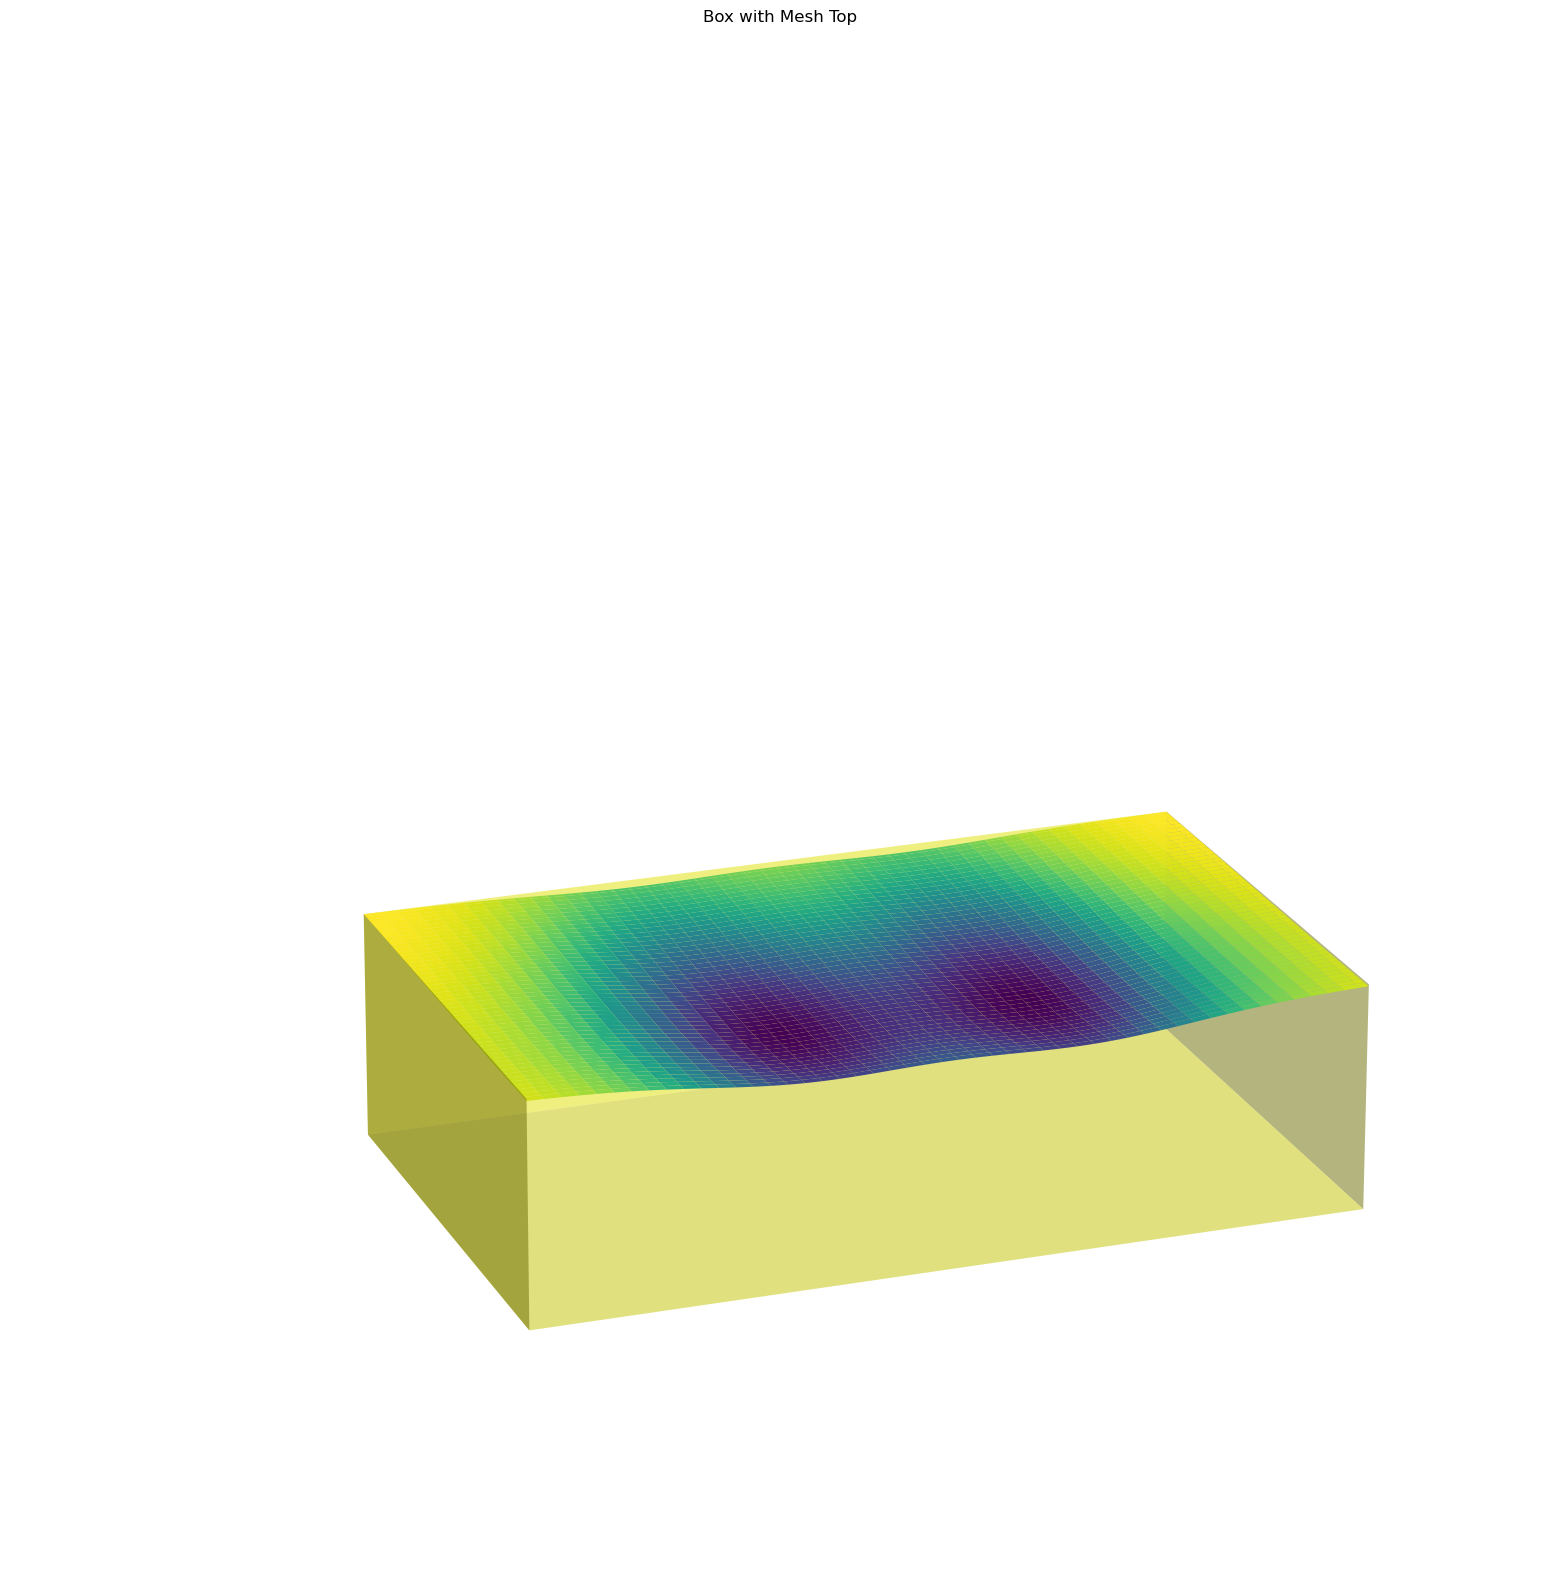

In [469]:
# Plotting
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the box - bottom and four side walls
# Bottom rectangle (0,0,0) to (max_x, max_y, 0)
ax.plot_surface([[0, max_x], [0, max_x]], [[0, 0], [max_y, max_y]], np.zeros((2, 2)), color='yellow', alpha=0.5)

# Side walls (4 vertical walls)
ax.plot_surface(np.array([[0, 0], [0, 0]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
#ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[0, 0], [0, 0]]), np.array([[0, 0], [stair_height, stair_height]]), color='gray', alpha=0.5)
ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[max_y, max_y], [max_y, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
ax.plot_surface(np.array([[max_x, max_x], [max_x, max_x]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)

# Top mesh surface (x_grid, y_grid, stair_H)
stair_H_fit = stair_height - H_fit
ax.plot_surface(X_mesh, Y_mesh, stair_H_fit, cmap='viridis', edgecolor='none')

# Set labels
ax.set_title('Box with Mesh Top')
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Height (cm)')

scaling = np.array([60, 50, 60])

ax.auto_scale_xyz(*[[0, scale] for scale in scaling])

ax.set_axis_off()
ax.view_init(elev=20, azim=250)
plt.savefig("figures/ascentDescentOutput.png", dpi=300)
plt.show()

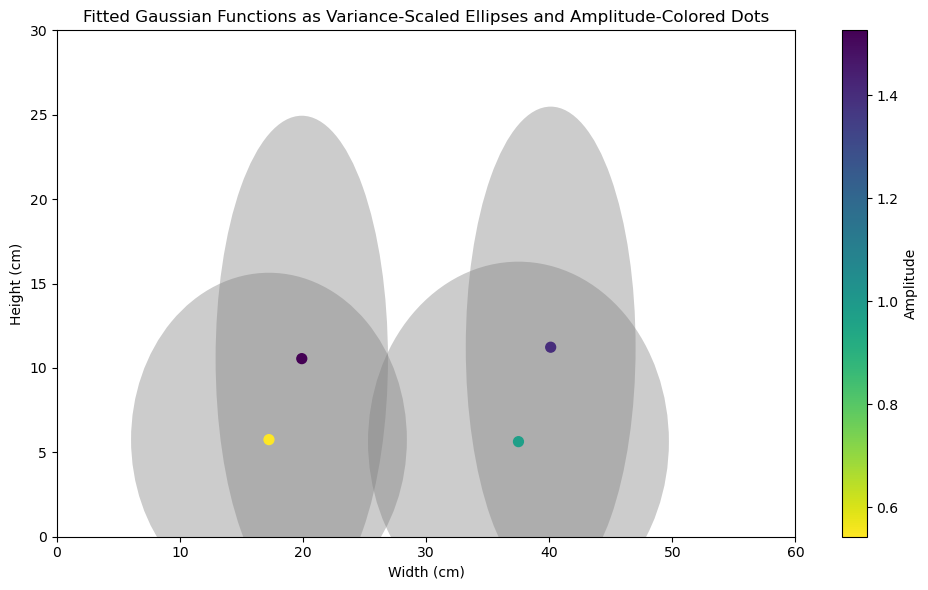

In [483]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))


# Plot the ellipse
for _, row in params_df.iterrows():
    x0, y0, sigma_x, sigma_y, amplitude = row
    
    ellipse = Ellipse(
        (x0, y0), width=2 * sigma_x, height=2 * sigma_y, edgecolor="none", facecolor="gray", alpha=0.4
    )
    ax.add_patch(ellipse)

scatter = ax.scatter(params_df["x0"], params_df["y0"], c=params_df["amplitude"], cmap="viridis_r", s=50)

# Set axis limits
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)

# Add labels
ax.set_xlabel("Width (cm)")
ax.set_ylabel("Height (cm)")
ax.set_title("Fitted Gaussian Functions as Variance-Scaled Ellipses and Amplitude-Colored Dots")

# Add a colorbar for amplitude
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Amplitude")

# Show the plot
plt.savefig("figures/ascentDescentGaussiansDiagram.png", dpi=300)
plt.tight_layout()
plt.show()

In [497]:
# Function to compute the value of the 2D Gaussian for a given (x, y)


def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude):
    x, y = xy
    return amplitude * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)))
    
# Function to calculate the integral of the Gaussian over a region
def integral_gaussian(x_max, y_max, x0, y0, sigma_x, sigma_y, amplitude):
    # Define the bounds for x and y
    def integrand(y, x):  # Note that dblquad expects the y-bound first
        return gaussian_2d((x, y), x0, y0, sigma_x, sigma_y, amplitude)
    
    # Perform the double integration using dblquad
    result, _ = dblquad(integrand, 0, x_max, lambda x: 0, lambda x: y_max)
    
    return result

params_df['integral'] = params_df.apply(
    lambda row: integral_gaussian(max_x, max_y, row['x0'], row['y0'], row['sigma_x'], row['sigma_y'], row['amplitude']),
    axis=1
)

params_df.round(2)

,x0,y0,sigma_x,sigma_y,amplitude,integral
0,37.50,5.63,12.23,10.66,0.98,532.92
1,17.22,5.75,11.21,9.89,0.54,252.41
2,40.11,11.23,6.90,14.25,1.40,596.72
3,19.89,10.55,7.00,14.39,1.53,655.76


In [506]:
type(params)

numpy.ndarray